In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pickle as pkl
import skimage
import yaml

import sys
sys.path.append('../cytof')

from hyperion_preprocess import cytof_read_data_roi
from hyperion_analysis import check_feature_distribution
from utils import save_multi_channel_img

## Parameters

In [2]:
class options:
    def __init__(self):
#         self.filename = "../../image_cytof_test_data/hyperion/cohort1/NP39264_B3/TM16MAR20_NP39264_b3_ROI_001_1.txt"
        self.filename = "../../image_cytof_test_data/hyperion/cohort1/NP37646_B5/TM14MAR20_NP37646_B5_ROI_001B_9.txt"
#         self.filename = "../../image_cytof_test_data/hyperion/cohort1/NP37646_B5/TM14MAR20_NP37646_B5_ROI_001_1.txt"
        self.outdir  = "../test_out/single_roi"
        self.slide   = "NP37646_B5"
        self.roi     = "ROI_001B_9"
        self.quality_control_thres = 50
        
        self.channel_dict = {
            'nuclei': ['191Ir(Ir191Di)', '193Ir(Ir193Di)', 'Histone3(Yb176Di)'],
            'membrane': []
        }
        self.keep_origs      = True
        self.channels_remove = []
        self.use_membrane    = True
        self.cell_radius     = 5
        self.normalize_qs    = [75, 99]

params = options()

## 1) Read and preprocess data
`cytof_read_data`

In [3]:
# read data: file name (.txt file) -> dataframe
cytof_img = cytof_read_data_roi(params.filename, params.slide, params.roi)
print("file: {}\nslide: {}, roi: {}".format(cytof_img.filename, cytof_img.slide, cytof_img.roi))

file: ../../image_cytof_test_data/hyperion/cohort1/NP37646_B5/TM14MAR20_NP37646_B5_ROI_001B_9.txt
slide: NP37646_B5, roi: ROI_001B_9


In [4]:
# quality control and make saving directory for the ROI
cytof_img.quality_control(thres=params.quality_control_thres)
if cytof_img.keep:

    outdir = os.path.join(params.outdir, params.slide, params.roi)
    print("Saving to {}".format(outdir))
    if not os.path.exists(outdir):
        os.makedirs(outdir)
        
    dir_channelimg = os.path.join(outdir, "channel_images")
    if not os.path.exists(dir_channelimg):
        os.makedirs(dir_channelimg)
        
    dir_feature = os.path.join(outdir, "feature")
    if not os.path.exists(dir_feature):
        os.makedirs(dir_feature)

Saving to ../test_out/single_roi/NP37646_B5/ROI_001B_9


In [5]:
# get the list of markers used when capturing the image
cytof_img.get_markers()
print("Markers: \n{}".format(cytof_img.markers))
print("\nChannels: \n{}".format(cytof_img.channels))

Markers: 
['116Cd', '140Ce', 'CD38', 'CD19', 'Vimentin', '144Nd', '145Nd', '146Nd', 'CD163', 'AE1-AE3', 'CD16', 'PD-L1', 'CD123', 'IFNg', '153Eu', 'CD11c', 'FoxP3', 'CD4', '157Gd', '158Gd', 'CD68', '160Dy', 'CD20', 'CD8', '163Dy', '164Er', 'PD-1', '166Er', 'GranzymeB', 'Ki-67', '169Tm', '170Yb', '171Yb', '172Yb', '173Yb', 'HLA-DR', '175Lu', 'Histone3', '191Ir', '193Ir', 'Cisplatin']

Channels: 
['116Cd(Cd116Di)', '140Ce(Ce140Di)', 'CD38(Pr141Di)', 'CD19(Nd142Di)', 'Vimentin(Nd143Di)', '144Nd(Nd144Di)', '145Nd(Nd145Di)', '146Nd(Nd146Di)', 'CD163(Sm147Di)', 'AE1-AE3(Nd148Di)', 'CD16(Sm149Di)', 'PD-L1(Nd150Di)', 'CD123(Eu151Di)', 'IFNg(Sm152Di)', '153Eu(Eu153Di)', 'CD11c(Sm154Di)', 'FoxP3(Gd155Di)', 'CD4(Gd156Di)', '157Gd(Gd157Di)', '158Gd(Gd158Di)', 'CD68(Tb159Di)', '160Dy(Dy160Di)', 'CD20(Dy161Di)', 'CD8(Dy162Di)', '163Dy(Dy163Di)', '164Er(Er164Di)', 'PD-1(Ho165Di)', '166Er(Er166Di)', 'GranzymeB(Er167Di)', 'Ki-67(Er168Di)', '169Tm(Tm169Di)', '170Yb(Yb170Di)', '171Yb(Yb171Di)', '172Yb(Yb

In [6]:
# preprocess: handle missing values (fill missing values with 0.)
cytof_img.preprocess()

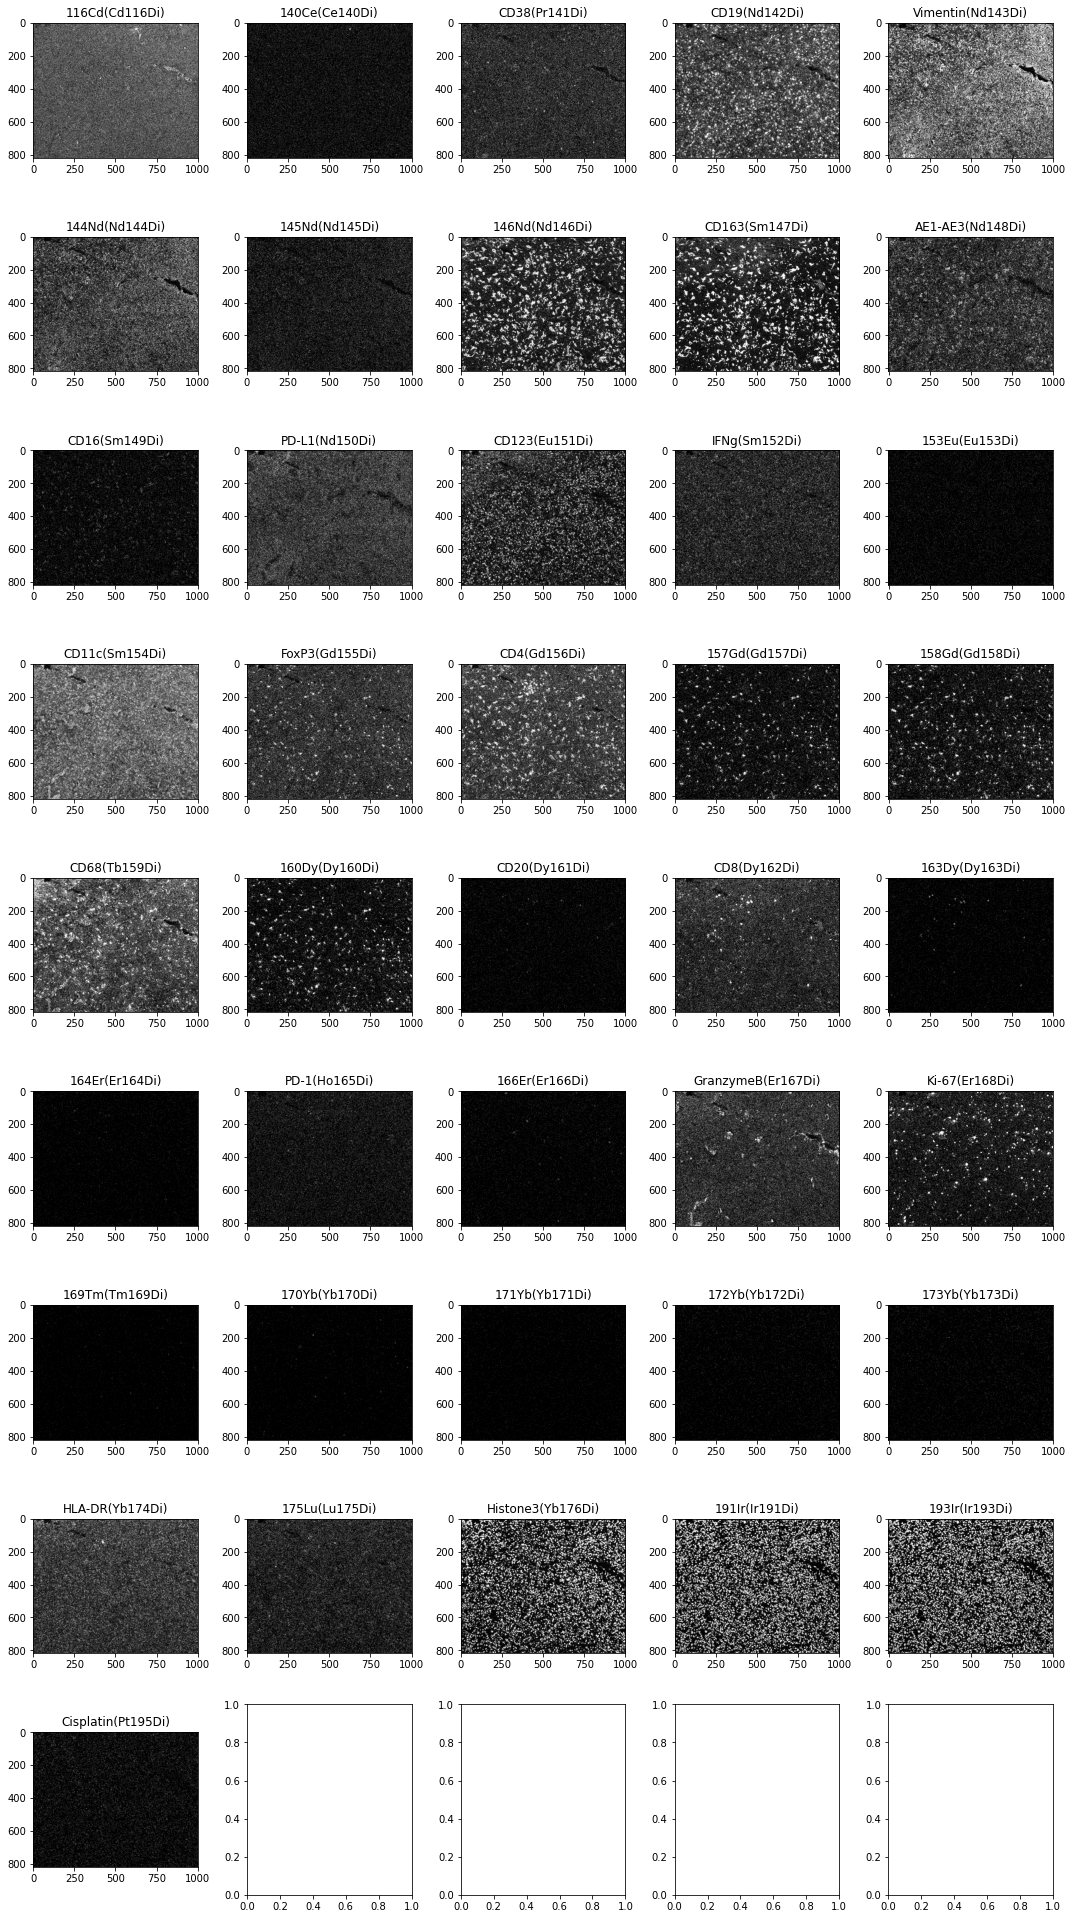

In [7]:
# (optional) check channels: get a glance of each channel image
cytof_img.check_channels()

In [8]:
# Get multi channel images
cytof_img.get_image()

Output image shape: [818, 1001, 41]


In [20]:
# (optional) save channel images
cytof_img.save_channel_images(dir_channelimg)

../cytof/utils.py:24: UserWarning: ../test_out/single_roi/NP37646_B5/ROI_001B_9/channel_images/169Tm(Tm169Di).png is a low contrast image
  skimage.io.imsave(savename, img)
../cytof/utils.py:24: UserWarning: ../test_out/single_roi/NP37646_B5/ROI_001B_9/channel_images/170Yb(Yb170Di).png is a low contrast image
  skimage.io.imsave(savename, img)
../cytof/utils.py:24: UserWarning: ../test_out/single_roi/NP37646_B5/ROI_001B_9/channel_images/171Yb(Yb171Di).png is a low contrast image
  skimage.io.imsave(savename, img)


In [10]:
# create a "readme.txt" file and write information of original markers and channels into it
f_info = open(os.path.join(outdir, 'readme.txt'), 'w')
f_info.write("Original markers: ")
f_info.write('\n{}'.format(", ".join(cytof_img.markers)))
f_info.write("\nOriginal channels: ")
f_info.write('\n{}'.format(", ".join(cytof_img.channels)))

661

In [12]:
# (optional) remove unwanted channels (change in "cids")
## take a close look at the channel images printed out; 
## alternatively, take a closer look at the saved channel images
### set to params (will be used in batch_process later)

channels_remove = ['140Ce(Ce140Di)', '153Eu(Eu153Di)','CD20(Dy161Di)','163Dy(Dy163Di)','164Er(Er164Di)','166Er(Er166Di)','169Tm(Tm169Di)',
'170Yb(Yb170Di)', '171Yb(Yb171Di)', '172Yb(Yb172Di)', '173Yb(Yb173Di)']

setattr(params, "channels_remove", channels_remove)

Output image shape: [818, 1001, 30]
Original list of channels: 
116Cd(Cd116Di), 140Ce(Ce140Di), CD38(Pr141Di), CD19(Nd142Di), Vimentin(Nd143Di), 144Nd(Nd144Di), 145Nd(Nd145Di), 146Nd(Nd146Di), CD163(Sm147Di), AE1-AE3(Nd148Di), CD16(Sm149Di), PD-L1(Nd150Di), CD123(Eu151Di), IFNg(Sm152Di), 153Eu(Eu153Di), CD11c(Sm154Di), FoxP3(Gd155Di), CD4(Gd156Di), 157Gd(Gd157Di), 158Gd(Gd158Di), CD68(Tb159Di), 160Dy(Dy160Di), CD20(Dy161Di), CD8(Dy162Di), 163Dy(Dy163Di), 164Er(Er164Di), PD-1(Ho165Di), 166Er(Er166Di), GranzymeB(Er167Di), Ki-67(Er168Di), 169Tm(Tm169Di), 170Yb(Yb170Di), 171Yb(Yb171Di), 172Yb(Yb172Di), 173Yb(Yb173Di), HLA-DR(Yb174Di), 175Lu(Lu175Di), Histone3(Yb176Di), 191Ir(Ir191Di), 193Ir(Ir193Di), Cisplatin(Pt195Di)

Updated list of channels: 
116Cd(Cd116Di), CD38(Pr141Di), CD19(Nd142Di), Vimentin(Nd143Di), 144Nd(Nd144Di), 145Nd(Nd145Di), 146Nd(Nd146Di), CD163(Sm147Di), AE1-AE3(Nd148Di), CD16(Sm149Di), PD-L1(Nd150Di), CD123(Eu151Di), IFNg(Sm152Di), CD11c(Sm154Di), FoxP3(Gd155Di), CD4(Gd

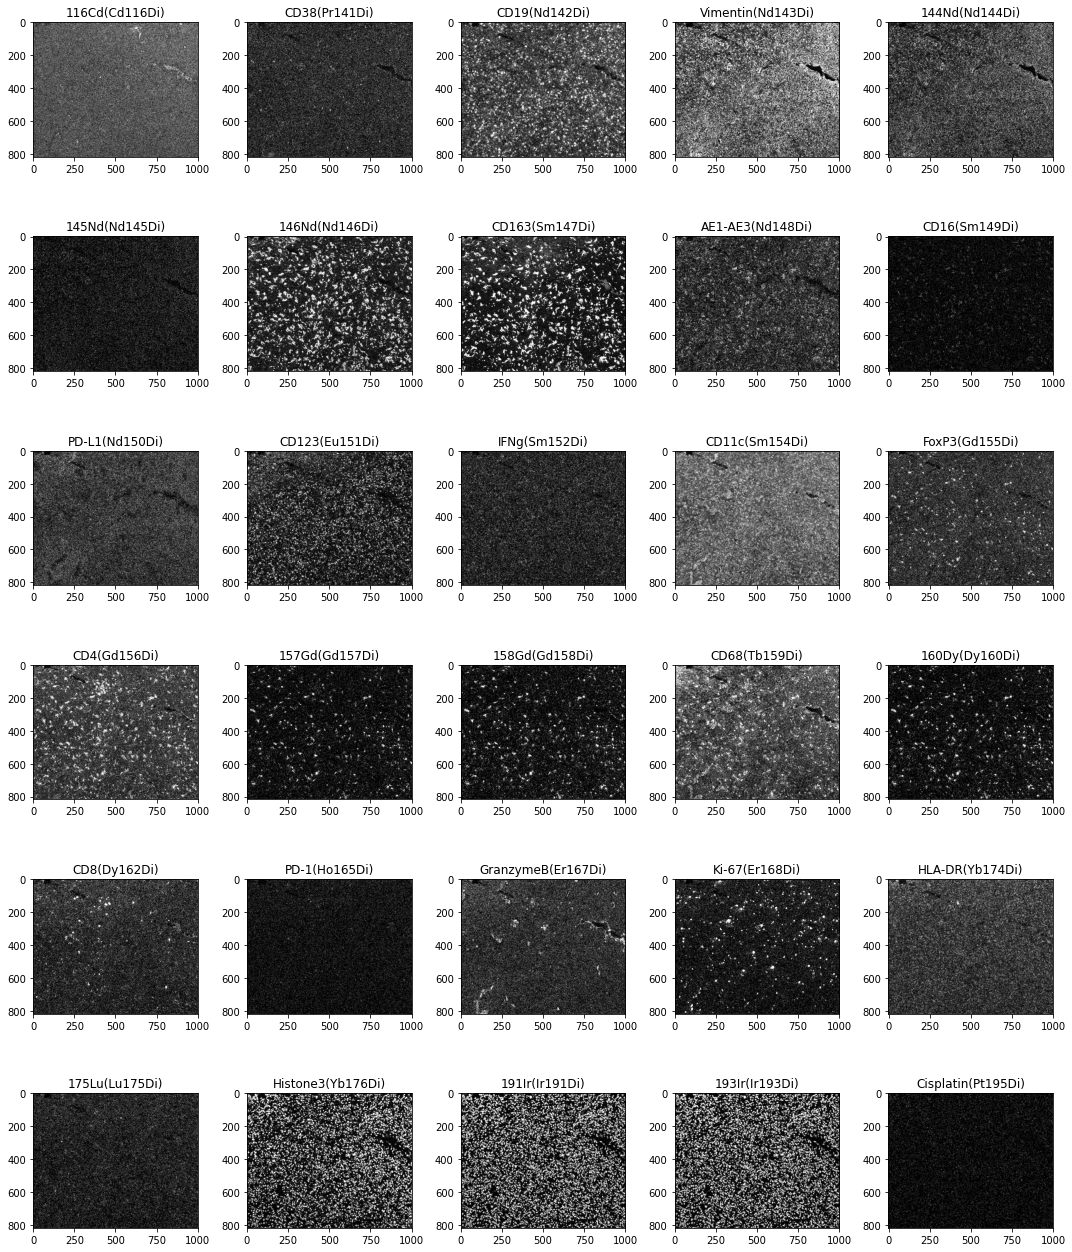

In [13]:
if hasattr(params,"channels_remove") and len(params.channels_remove) > 0:
    cytof_img.remove_special_channels(params.channels_remove)
    # Get multi channel images (again)
    cytof_img.get_image()
    
    # (optional) save channel images
    cytof_img.save_channel_images(dir_channelimg)
    
    print("Original list of channels: \n{}".format(', '.join(cytof_img.raw_channels)))
    print("\nUpdated list of channels: \n{}".format(', '.join(cytof_img.channels)))
    
    # (optional) check channels after removing unwanted channels: get a glance of each channel image
    cytof_img.check_channels()

#### Visualization in color
Multiple options available

In [14]:
vis_channel_names = ['Vimentin(Nd143Di)','191Ir(Ir191Di)','CD163(Sm147Di)','CD8(Dy162Di)',
                     'CD4(Gd156Di)','Ki-67(Er168Di)','AE1-AE3(Nd148Di)']
vis_range = {
    'h0': 500,
    'h1': 800,
    'w0': 0,
    'w1': 300
}

vis_channel_ids   = [3, 27, 7]

../cytof/classes.py:213: UserWarning: Visualizing more than 3 channels the same time results in deteriorated visualization.                 It is not recommended!
  warnings.warn(


Visualizing channels: Vimentin(Nd143Di), 191Ir(Ir191Di), CD163(Sm147Di), CD8(Dy162Di), CD4(Gd156Di), Ki-67(Er168Di), AE1-AE3(Nd148Di)
Visualizing... 
Vimentin(Nd143Di) in red
191Ir(Ir191Di) in green
CD163(Sm147Di) in blue
CD8(Dy162Di) in cyan
CD4(Gd156Di) in magenta
Ki-67(Er168Di) in yellow
AE1-AE3(Nd148Di) in white



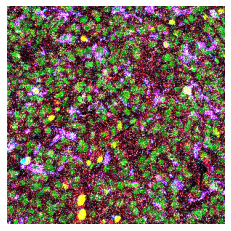

In [15]:
# (optional 1.1) visualize selected channels in pseudoRGB and save, using channel names

pseudoRGB, quantiles, color_pool = cytof_img.visualize_channels(channel_names=vis_channel_names, 
                                                                              visualize=False)
fig, ax = plt.subplots(1,1)
ax.imshow(pseudoRGB[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'], :])
plt.axis('off')

# save visualization
_channel_ids = [cytof_img.channels.index(_) for _ in vis_channel_names]
save_multi_channel_img(
    skimage.img_as_ubyte(
        pseudoRGB[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'], :]), 
    os.path.join(dir_channelimg, 
                 "fig3_channels_{}.png".format('_'.join([cytof_img.markers[x] for x in _channel_ids]))
                ))

Visualizing channels: Vimentin(Nd143Di), 191Ir(Ir191Di), CD163(Sm147Di)
Visualizing... 
Vimentin(Nd143Di) in red
191Ir(Ir191Di) in green
CD163(Sm147Di) in blue



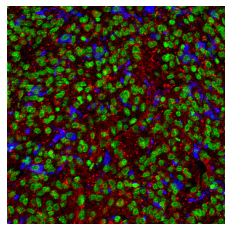

In [16]:
# (optional 1.2) visualize selected channels in pseudoRGB and save, using channel names, using channel indices


pseudoRGB, quantiles, color_pool = cytof_img.visualize_channels(channel_ids=vis_channel_ids, 
                                                                              visualize=False)
fig, ax = plt.subplots(1,1)
ax.imshow(pseudoRGB[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'], :])
plt.axis('off')

save_multi_channel_img(
    skimage.img_as_ubyte(
        pseudoRGB[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'], :]), 
    os.path.join(dir_channelimg, 
                 "fig3_channels_{}.png".format('_'.join([cytof_img.markers[x] for x in vis_channel_ids]))
                ))

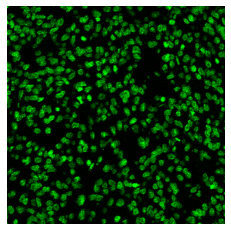

In [17]:
# (optional 2) visualize selected one channel in specified color (choose from "red", "green", and "blue")

channel_name = '191Ir(Ir191Di)'
color = "green"

vis_im = cytof_img.visualize_single_channel(channel_name=channel_name, color=color)
fig, ax = plt.subplots(1,1)
ax.imshow(vis_im[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'], :])
plt.axis('off')

_channel_ids = [cytof_img.channels.index(_) for _ in vis_channel_names]
save_multi_channel_img(
    skimage.img_as_ubyte(vis_im[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'], :]), 
    os.path.join(dir_channelimg, "channel_{}_in_{}.png".format(channel_name, color)))

## 2) nuclei & membrane channels and visualize
`define_special_channel`, `cytof_txt2img`, `cytof_merge_channels`

#### Define special channels: nuclei & membrane channel(s)

In [18]:
channels_ = cytof_img.channels[:]
print("\nList of channels before defining special channel(s): \n{}".format(', '.join(channels_)))
# define special channels (if desired)
channels_rm = cytof_img.define_special_channels(params.channel_dict)


# remove unwanted channels (if desired)
if not params.keep_origs: # if not keeping original channels
    cytof_img.remove_special_channels(channels_rm)
print("\nUpdated list of channels after defining special channel(s): \n{}".format(', '.join(cytof_img.channels)))


List of channels before defining special channel(s): 
116Cd(Cd116Di), CD38(Pr141Di), CD19(Nd142Di), Vimentin(Nd143Di), 144Nd(Nd144Di), 145Nd(Nd145Di), 146Nd(Nd146Di), CD163(Sm147Di), AE1-AE3(Nd148Di), CD16(Sm149Di), PD-L1(Nd150Di), CD123(Eu151Di), IFNg(Sm152Di), CD11c(Sm154Di), FoxP3(Gd155Di), CD4(Gd156Di), 157Gd(Gd157Di), 158Gd(Gd158Di), CD68(Tb159Di), 160Dy(Dy160Di), CD8(Dy162Di), PD-1(Ho165Di), GranzymeB(Er167Di), Ki-67(Er168Di), HLA-DR(Yb174Di), 175Lu(Lu175Di), Histone3(Yb176Di), 191Ir(Ir191Di), 193Ir(Ir193Di), Cisplatin(Pt195Di)
Defining channel 'nuclei' by summing up channels: 191Ir(Ir191Di), 193Ir(Ir193Di), Histone3(Yb176Di).
Output image shape: [818, 1001, 31]

Updated list of channels after defining special channel(s): 
116Cd(Cd116Di), CD38(Pr141Di), CD19(Nd142Di), Vimentin(Nd143Di), 144Nd(Nd144Di), 145Nd(Nd145Di), 146Nd(Nd146Di), CD163(Sm147Di), AE1-AE3(Nd148Di), CD16(Sm149Di), PD-L1(Nd150Di), CD123(Eu151Di), IFNg(Sm152Di), CD11c(Sm154Di), FoxP3(Gd155Di), CD4(Gd156Di), 157Gd

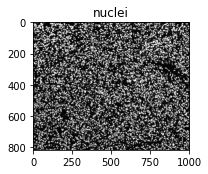

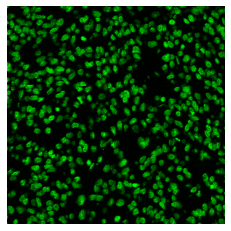

In [19]:
# (optional) check channels: get a glance of each added channel image
vis_range = {
    'h0': 500,
    'h1': 800,
    'w0': 0,
    'w1': 300
}

vis_channels = [k for (k, itm) in params.channel_dict.items() if len(itm)>0] #['nuclei', 'membrane']
cytof_img.check_channels(channels=vis_channels)

# visualize in color image (green)
color = "green"
for channel_name in vis_channels:
    vis_im = cytof_img.visualize_single_channel(channel_name=channel_name, color=color)
    fig, ax = plt.subplots(1,1)
    ax.imshow(vis_im[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'],:])
    plt.axis('off')

    _channel_ids = [cytof_img.channels.index(_) for _ in vis_channel_names]
    save_multi_channel_img(
        skimage.img_as_ubyte(vis_im[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'], :]), 
        os.path.join(dir_channelimg, "channel_{}_in_{}.png".format(channel_name, color)))

In [20]:
# (optional) save newly added channel images
cytof_img.save_channel_images(dir_channelimg, channels=vis_channels)

##### Visualize selected channels in pseudoRGB after definine special channel(s)

In [21]:
vis_range = {
    'h0': 500,
    'h1': 800,
    'w0': 0,
    'w1': 300
}
vis_channels_RGB = ['Vimentin(Nd143Di)','nuclei','CD163(Sm147Di)','CD8(Dy162Di)',
                     'CD4(Gd156Di)','Ki-67(Er168Di)','AE1-AE3(Nd148Di)']
vis_channels_ids_RGB = [3, 30, 7]

../cytof/classes.py:213: UserWarning: Visualizing more than 3 channels the same time results in deteriorated visualization.                 It is not recommended!
  warnings.warn(


Visualizing channels: Vimentin(Nd143Di), nuclei, CD163(Sm147Di), CD8(Dy162Di), CD4(Gd156Di), Ki-67(Er168Di), AE1-AE3(Nd148Di)
Visualizing... 
Vimentin(Nd143Di) in red
nuclei in green
CD163(Sm147Di) in blue
CD8(Dy162Di) in cyan
CD4(Gd156Di) in magenta
Ki-67(Er168Di) in yellow
AE1-AE3(Nd148Di) in white



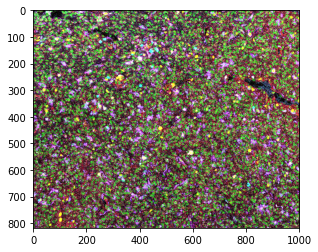

(-0.5, 299.5, 299.5, -0.5)

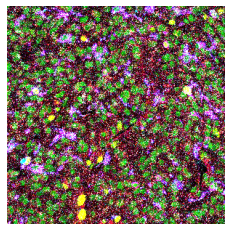

In [22]:
pseudoRGB, quantiles, color_pool = cytof_img.visualize_channels(channel_names=vis_channels_RGB, 
                                                                              visualize=True)

fig, ax = plt.subplots(1,1)
ax.imshow(pseudoRGB[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'],:])
plt.axis('off')

# _save_multi_channel_img(skimage.img_as_ubyte(pseudoRGB[0:300, 600:900, :]), 
#                         os.path.join(dir_channelimg, 
#                                      "channels_{}.png".format('_'.join([cytof_img.markers[x] for x in vis_channel_ids]))))

Visualizing channels: Vimentin(Nd143Di), nuclei, CD163(Sm147Di)
Visualizing... 
Vimentin(Nd143Di) in red
nuclei in green
CD163(Sm147Di) in blue



(-0.5, 299.5, 299.5, -0.5)

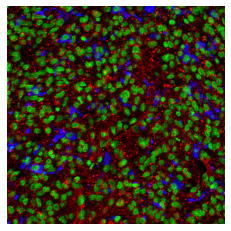

In [23]:
pseudoRGB, quantiles, color_pool = cytof_img.visualize_channels(channel_ids=vis_channels_ids_RGB, 
                                                                              visualize=False)

fig, ax = plt.subplots(1,1)
ax.imshow(pseudoRGB[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'],:])
plt.axis('off')

In [24]:
f_info.write("\nChannels removed: ")
f_info.write("\n{}".format(", ".join(params.channels_remove+channels_rm)))
f_info.write("\nFinal markers: ")
f_info.write("\n{}".format(', '.join(cytof_img.markers)))
f_info.write("\nFinal channels: ")
f_info.write("\n{}".format(', '.join(cytof_img.channels)))
f_info.close()

## 3) Nuclei and cell segmentation
`get_seg` (class method), `visualize_segmentation`

#### Get nuclei and cell segmentation

Nuclei segmentation...


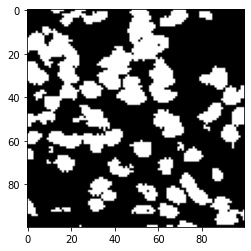

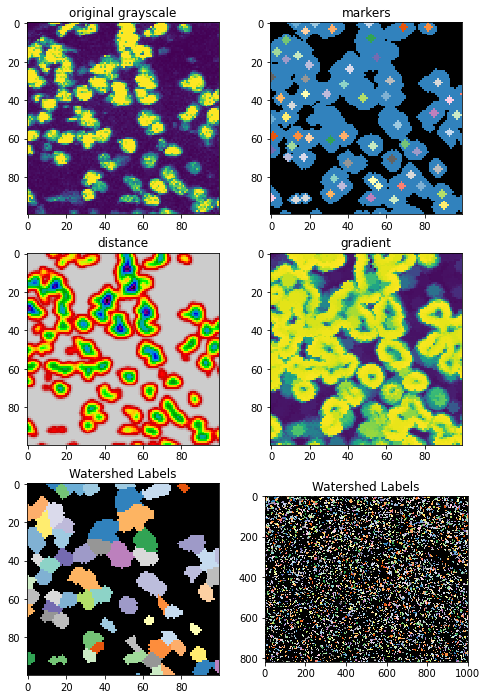

Cell segmentation...


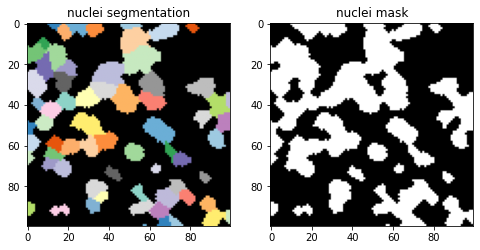

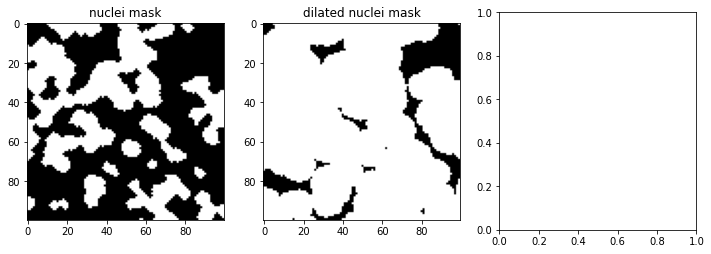

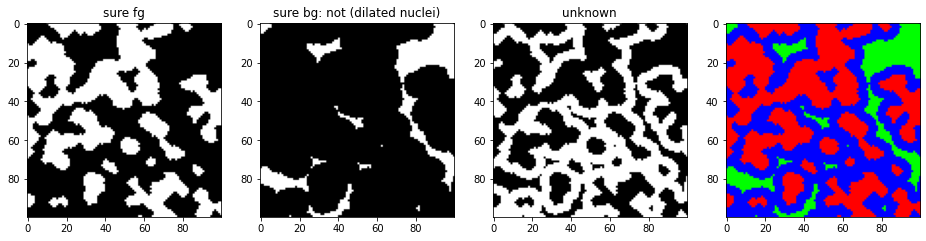

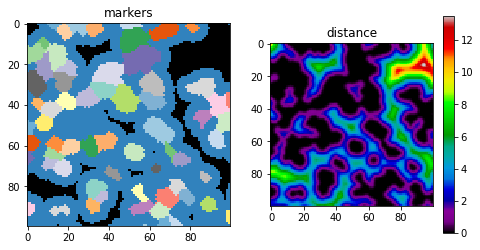

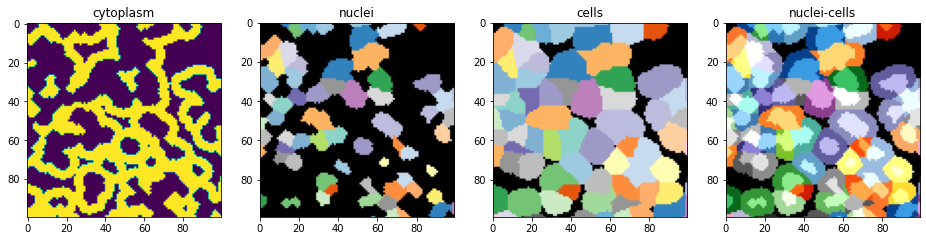

In [25]:
nuclei_seg, cell_seg = cytof_img.get_seg(use_membrane=params.use_membrane, 
                                         radius=params.cell_radius, # 10
                                         show_process=True)

#### Visualization nuclei and/or cell segmentation output in pseudo RGB image with boundaries marked

Visualizing... 
nuclei in red
116Cd(Cd116Di) in green

nuclei boundary marked by white


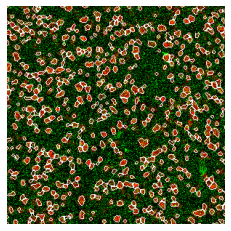

In [26]:
vis_range = {
    'h0': 500,
    'h1': 800,
    'w0': 0,
    'w1': 300
}

marked_image_nuclei = cytof_img.visualize_seg(segtype="nuclei", show=False)
plt.imshow(marked_image_nuclei[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'],:])
plt.axis('off')
plt.show()

# # (optional) save segmentation visualization
# _save_multi_channel_img(skimage.img_as_ubyte(marked_image_nuclei), os.path.join(savedir, "nuclei_seg.png"))
save_multi_channel_img(
    skimage.img_as_ubyte(marked_image_nuclei[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'],:]), 
    os.path.join(outdir, "nuclei_seg_subset.png"))

Visualizing... 
nuclei in red
116Cd(Cd116Di) in green

cell boundary marked by white


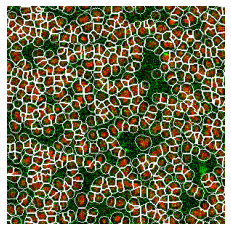

In [27]:
# visualize cell segmentation with boundaries marked
# note: showing a selected region

marked_image_cell = cytof_img.visualize_seg(segtype="cell", show=False)
plt.imshow(marked_image_cell[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'],:])
plt.axis('off')
plt.show()

# # (optional) save segmentation visualization
# _save_multi_channel_img(skimage.img_as_ubyte(marked_image_cell), os.path.join(savedir, "cell_seg.png"))
save_multi_channel_img(
    skimage.img_as_ubyte(marked_image_cell[vis_range['h0']:vis_range['h1'], vis_range['w0']:vis_range['w1'], :]), 
    os.path.join(outdir, "cell_seg_subset.png"))

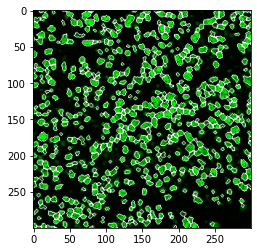

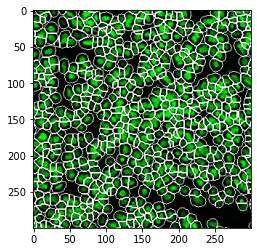

In [28]:
## Note: temp only for making this plot
## visualize with single channel and boundary

from skimage.segmentation import mark_boundaries
# from utils import save_multi_channel_img
# import skimage

vis_im = cytof_img.visualize_single_channel(channel_name="nuclei", 
                             color="green", quantile=None, 
                             visualize=False)

marked_image_nuclei_ = mark_boundaries(vis_im,
                               cytof_img.nuclei_seg, mode='inner', color=(1, 1, 1), background_label=1)
marked_image_cell_ = mark_boundaries(vis_im,
                               cytof_img.cell_seg, mode='inner', color=(1, 1, 1), background_label=1)
# plt.figure(figsize=(8,8))
plt.imshow(marked_image_nuclei_[0:300, 600:900,:])
plt.show()
# plt.figure(figsize=(8,8))
plt.imshow(marked_image_cell_[0:300, 600:900,:])
plt.show()

save_multi_channel_img(skimage.img_as_ubyte(marked_image_nuclei_[0:300, 600:900,:]), 
                        os.path.join(outdir, "nuclei_seg_subset_.png"))

save_multi_channel_img(skimage.img_as_ubyte(marked_image_cell_[0:300, 600:900,:]), 
                        os.path.join(outdir, "cell_seg_subset_.png"))

In [50]:
# (optional) save CytofImage class instance
savename_cytof_img = os.path.join(outdir, "cytof_img.pkl")
cytof_img.save_cytof(savename_cytof_img)

## 4) Feature extraction
`extract_feature`, `check_feature_distribution`

In [29]:
cytof_img.extract_features(params.filename)

cytof_img.df_feature.head()

100%|███████████████████████████████████████████████████████████| 5003/5003 [18:01<00:00,  4.63it/s]


filename  id  coordinate_x  \
0  ../../image_cytof_test_data/hyperion/cohort1/N...   2     13.062500   
1  ../../image_cytof_test_data/hyperion/cohort1/N...   3     24.625000   
2  ../../image_cytof_test_data/hyperion/cohort1/N...   4     50.423077   
3  ../../image_cytof_test_data/hyperion/cohort1/N...   5     67.127660   
4  ../../image_cytof_test_data/hyperion/cohort1/N...   6     81.045455   

   coordinate_y  116Cd(Cd116Di)_nuclei_sum  CD38(Pr141Di)_nuclei_sum  \
0      0.875000                     20.073                     2.139   
1      2.145833                     70.949                    26.772   
2      0.807692                     30.382                     9.493   
3      3.702128                    133.121                    29.188   
4      1.727273                     31.511                     5.139   

   CD19(Nd142Di)_nuclei_sum  Vimentin(Nd143Di)_nuclei_sum  \
0                    18.213                        38.964   
1                    94.630                      1857.741   
2                    55.653                       595.533   
3                   133.268                      1201.990   
4                    12.270                       222.834   

   144Nd(Nd144Di)_nuclei_sum  145Nd(Nd145Di)_nuclei_sum  ...  \
0                      1.000                      0.000  ...   
1                     52.200                      6.606  ...   
2                     24.452                      7.052  ...   
3                     48.587                      6.679  ...   
4                      4.582                      2.337  ...   

   convex_area_cell  eccentricity_cell  extent_cell  filled_area_cell  \
0                52           0.835131     0.638889                46   
1               106           0.725553     0.696970                92   
2                48           0.988758     0.833333                45   
3               190           0.729949     0.897059               183   
4               110           0.666026     0.807692               105   

   major_axis_length_cell  minor_axis_length_cell  orientation_cell  \
0               11.028504                6.066244          1.429883   
1               13.565386                9.335238          0.387752   
2               19.679228                2.942591         -1.525072   
3               18.744293               12.811756          1.515929   
4               13.585568               10.133859         -1.337601   

   perimeter_cell  solidity_cell  pa_ratio_cell  
0       26.692388       0.884615      15.488774  
1       39.106602       0.867925      16.623112  
2       35.414214       0.937500      27.870367  
3       51.071068       0.963158      14.252754  
4       37.899495       0.954545      13.679731  

[5 rows x 146 columns]

In [69]:
# (optional) save extracted feature
cytof_img.df_feature.to_csv(os.path.join(dir_feature, "feature_summary.csv"), index=False)

#### Check feature distribution

In [30]:
# print the keys of extracted features (feature subsets)
print(cytof_img.features.keys())

dict_keys(['nuclei_morphology', 'cell_morphology', 'cell_sum', 'cell_ave', 'nuclei_sum', 'nuclei_ave'])


116Cd(Cd116Di)_cell_sum


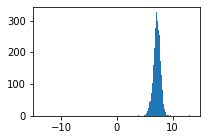

CD38(Pr141Di)_cell_sum


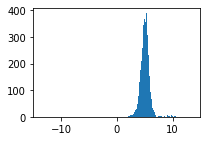

CD19(Nd142Di)_cell_sum


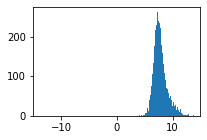

Vimentin(Nd143Di)_cell_sum


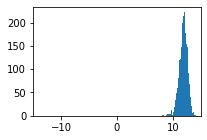

144Nd(Nd144Di)_cell_sum


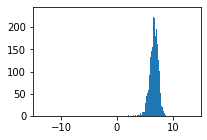

145Nd(Nd145Di)_cell_sum


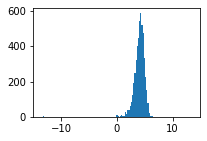

146Nd(Nd146Di)_cell_sum


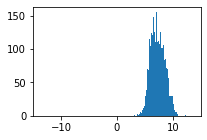

CD163(Sm147Di)_cell_sum


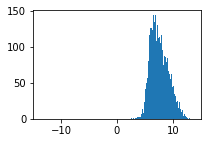

AE1-AE3(Nd148Di)_cell_sum


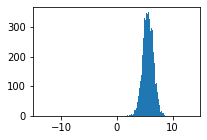

CD16(Sm149Di)_cell_sum


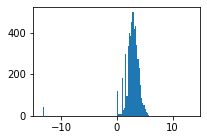

PD-L1(Nd150Di)_cell_sum


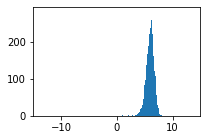

CD123(Eu151Di)_cell_sum


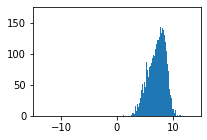

IFNg(Sm152Di)_cell_sum


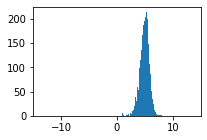

CD11c(Sm154Di)_cell_sum


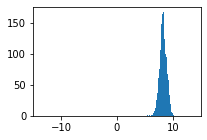

FoxP3(Gd155Di)_cell_sum


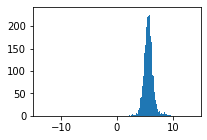

CD4(Gd156Di)_cell_sum


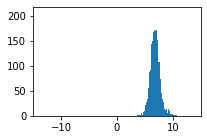

157Gd(Gd157Di)_cell_sum


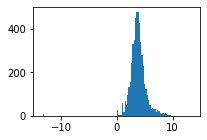

158Gd(Gd158Di)_cell_sum


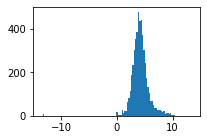

CD68(Tb159Di)_cell_sum


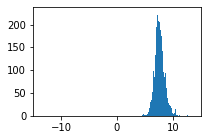

160Dy(Dy160Di)_cell_sum


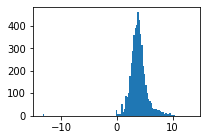

CD8(Dy162Di)_cell_sum


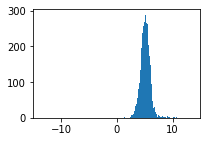

PD-1(Ho165Di)_cell_sum


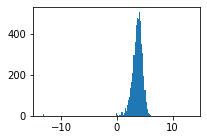

GranzymeB(Er167Di)_cell_sum


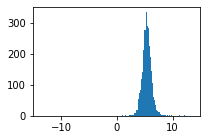

Ki-67(Er168Di)_cell_sum


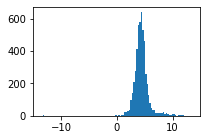

HLA-DR(Yb174Di)_cell_sum


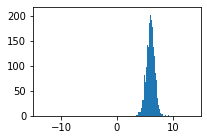

175Lu(Lu175Di)_cell_sum


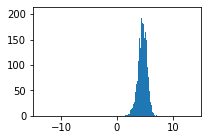

Histone3(Yb176Di)_cell_sum


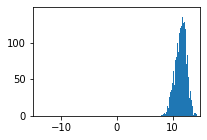

191Ir(Ir191Di)_cell_sum


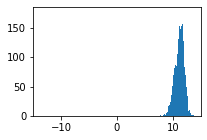

193Ir(Ir193Di)_cell_sum


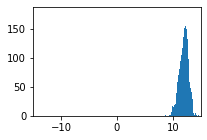

Cisplatin(Pt195Di)_cell_sum


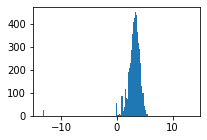

In [31]:
check_feature_distribution(feature_summary_df=cytof_img.df_feature, features=cytof_img.features['cell_sum'])

### 4.1) Log transform and qantile normalization
`feature_quantile_normalization`

q-th percenrile normalization with q: 75, 99
75th percentile: 210.43274999999997
99th percentile: 7456.578559999987


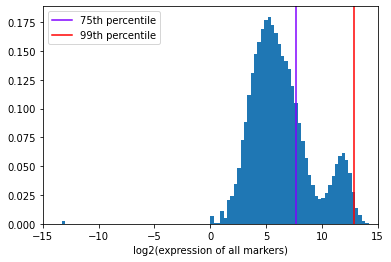

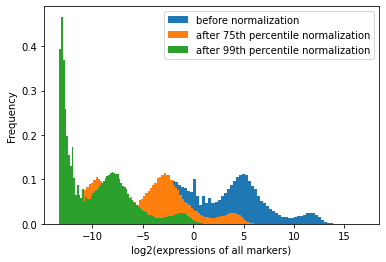

In [36]:
'''
(1) Calculate [75th and 99th] (default) quantiles for all single cell & single nuclei data (cell sum & nuclei sum of all markers)
(2) Perform feature quantile normalization
(3) Attach normalized feature as new attributes to cytof_img
'''
print(f"q-th percenrile normalization with q: {', '.join(map(str, params.normalize_qs))}")
cytof_img.feature_quantile_normalization(qs=params.normalize_qs)

In [37]:
# save single ROI parameters
params_save = vars(params)

# (optional) remove those won't be used to process the cohort
# params_save.pop('filename')
# params_save.pop('outdir')
params_save.pop('slide')
params_save.pop('roi')

yaml.dump(vars(params), open(os.path.join(outdir, "params.txt"), "w"))

In [88]:
import copy

# feature scaling part
dfs_scale_params = {}
s_features = [col for key, features in cytof_img.features.items() \
                      for f in features \
                      for col in cytof_img.df_feature.columns if col.startswith(f)]
seen = 0 # always 0 for a single file

## calculate scaling parameters
for q, quantile in cytof_img.dict_quantiles.items():
    n_attr = f"df_feature_{q}normed"
    df_normed = getattr(cytof_img, n_attr)
    # save the normalized features to csv
#     df_normed.to_csv(os.path.join(feat_dirs[f"{q}normed"],
#                                   "{}_{}_feature_summary.csv".format(slide, roi)),
#                      index=False)
    if seen == 0:
        dfs_scale_params[q] = df_normed[s_features]
        dict_quantiles = cytof_img.dict_quantiles
    else:
        # dfs_scale_params[q] = dfs_scale_params[q].append(df_normed[s_features], ignore_index=True)
        dfs_scale_params[q] = pd.concat([dfs_scale_params[q], df_normed[s_features]])

        
for q in cytof_img.dict_quantiles.keys():
    n_attr = f"df_feature_{q}normed"
    n_attr_scaled = f"{n_attr}_scaled"
    
    df_scale_params = dfs_scale_params[q].mean().to_frame(name="mean").transpose()
    df_scale_params = pd.concat([df_scale_params, dfs_scale_params[q].std().to_frame(name="std").transpose()])
#     df_scale_params.to_csv(os.path.join(outdir, f"{q}normed_scale_params.csv"), index=False)

    m = df_scale_params[df_scale_params.columns].iloc[0] # mean
    s = df_scale_params[df_scale_params.columns].iloc[1] # std.dev
#     print(m, s)
    
    df_feat = copy.deepcopy(getattr(cytof_img, n_attr))
    
    assert len([x for x in df_scale_params.columns if x not in df_scale_params.columns]) == 0

    # scale
    df_feat[df_scale_params.columns] = (df_feat[df_scale_params.columns] - m) / s
    setattr(cytof_img, n_attr_scaled, df_feat)


savename_cytof_img = os.path.join(outdir, "cytof_img.pkl")
cytof_img.save_cytof(savename_cytof_img)

In [100]:
# make the file for cohort with only this image

df_test_cohort1 = pd.DataFrame(
    {"Slide": [cytof_img.slide], 
     "ROI": [os.path.basename(params.filename)], 
     "path": [os.path.dirname(params.filename)]})
df_test_cohort1.to_csv(os.path.join(outdir, "test_cohort.csv"), index=False)

In [101]:
df_test_cohort1

Slide                                  ROI  \
0  NP37646_B5  TM14MAR20_NP37646_B5_ROI_001B_9.txt   

                                                path  
0  ../../image_cytof_test_data/hyperion/cohort1/N...

In [72]:
df_io = pd.DataFrame({
    "Slide": [cytof_img.slide], 
    "ROI": [cytof_img.roi], 
    "path": [os.path.dirname(params.filename)],
    "output_file": [savename_cytof_img]
})
df_io.to_csv(os.path.join(outdir, "input_output.csv"), index=False)

In [45]:
# make the file of test cohort

import pandas as pd

df_test_cohort = pd.DataFrame(columns=["Slide", "ROI", "path"])
dir_data = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/github/image_cytof_test_data/hyperion/cohort1/"
for slide in os.listdir(dir_data):
    pth = os.path.join(dir_data, slide)
    if os.path.isfile(pth):
        continue
    for roi in os.listdir(pth):
        if roi.endswith('.txt'):
            df_test_cohort = pd.concat((df_test_cohort, pd.DataFrame.from_dict([{"Slide": slide, "ROI": roi, "path": pth}])))
df_test_cohort.to_csv(os.path.join(dir_data, "test_cohort.csv"), index=False)

Slide                                  ROI  \
0  NP39264_B3   TM16MAR20_NP39264_b3_ROI_002_2.txt   
0  NP39264_B3   TM16MAR20_NP39264_b3_ROI_001_1.txt   
0  NP39264_B3   TM16MAR20_NP39264_b3_ROI_003_3.txt   
0  NP37646_B5  TM14MAR20_NP37646_B5_ROI_001B_9.txt   
0  NP37646_B5   TM14MAR20_NP37646_B5_ROI_003_3.txt   
0  NP37646_B5   TM14MAR20_NP37646_B5_ROI_001_1.txt   
0  NP37646_B5   TM14MAR20_NP37646_B5_ROI_002_2.txt   
0  NP37646_B5   TM14MAR20_NP37646_B5_ROI_006_6.txt   
0  NP37646_B5   TM14MAR20_NP37646_B5_ROI_004_4.txt   
0  NP37646_B5   TM14MAR20_NP37646_B5_ROI_007_7.txt   
0  NP37646_B5   TM14MAR20_NP37646_B5_ROI_008_8.txt   
0  NP37646_B5   TM14MAR20_NP37646_B5_ROI_005_5.txt   

                                                path  
0  /archive/DPDS/Xiao_lab/shared/hudanyun_sheng/g...  
0  /archive/DPDS/Xiao_lab/shared/hudanyun_sheng/g...  
0  /archive/DPDS/Xiao_lab/shared/hudanyun_sheng/g...  
0  /archive/DPDS/Xiao_lab/shared/hudanyun_sheng/g...  
0  /archive/DPDS/Xiao_lab/shared/hudanyun_sheng/g...  
0  /archive/DPDS/Xiao_lab/shared/hudanyun_sheng/g...  
0  /archive/DPDS/Xiao_lab/shared/hudanyun_sheng/g...  
0  /archive/DPDS/Xiao_lab/shared/hudanyun_sheng/g...  
0  /archive/DPDS/Xiao_lab/shared/hudanyun_sheng/g...  
0  /archive/DPDS/Xiao_lab/shared/hudanyun_sheng/g...  
0  /archive/DPDS/Xiao_lab/shared/hudanyun_sheng/g...  
0  /archive/DPDS/Xiao_lab/shared/hudanyun_sheng/g...

In [73]:
!pip freeze

anndata==0.8.0
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
certifi @ file:///opt/conda/conda-bld/certifi_1655968806487/work/certifi
contourpy==1.0.5
cycler==0.11.0
debugpy @ file:///tmp/build/80754af9/debugpy_1637091796427/work
decorator @ file:///opt/conda/conda-bld/decorator_1643638310831/work
entrypoints @ file:///tmp/build/80754af9/entrypoints_1649926445639/work
executing @ file:///opt/conda/conda-bld/executing_1646925071911/work
fonttools==4.38.0
h5py==3.7.0
igraph==0.10.2
imageio==2.22.2
importlib-metadata==5.0.0
ipykernel @ file:///tmp/build/80754af9/ipykernel_1646982648551/work/dist/ipykernel-6.9.1-py3-none-any.whl
ipython @ file:///opt/conda/conda-bld/ipython_1657652213665/work
ipywidgets==8.0.2
jedi @ file:///tmp/build/80754af9/jedi_1644315233700/work
joblib==1.2.0
jupyter-client @ file:///opt/conda/conda-bld/jupyter_client_1650622202839/work
jupyter-core @ file:///opt/conda/conda-bld/j